In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import torch
import torch.nn as nn
# import torch.autograd Variable as V

torch.__version__

'1.3.1'

In [130]:
def sample_targets(size=1):
    where = np.random.rand(size) > 0.7
    a = np.random.normal(-3, 0.5, size)
    b = np.random.normal( 3, 0.5, size)
    return torch.Tensor(np.where(where, a, b).reshape(size, 1))

def sample_normal(size=1):
    return torch.normal(0, 1, (size, 1))

(torch.Size([1000, 1]), torch.Size([1000, 1]))

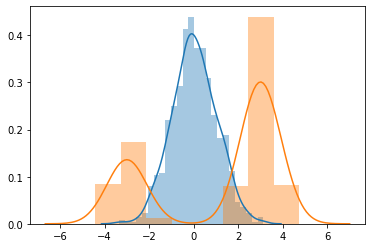

In [131]:
X = sample_normal(1000)
Y = sample_targets(1000)

sns.distplot(X)
sns.distplot(Y)

X.shape, Y.shape

In [132]:
def dense(inp, out, a=nn.Tanh):
    return [
        nn.Linear(inp, out),
        a(),
    ]

In [133]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            *dense(1 , 20),
            *dense(20, 20),
            *dense(20,  1, nn.Identity),
        )
        
    def forward(self, bs):
        noise = sample_normal(bs)
        return self.net(noise)
    
G = Generator()

In [134]:
D = nn.Sequential(
    *dense(1 , 20),
#     *dense(20, 20),
    *dense(20,  1, nn.Sigmoid),
)

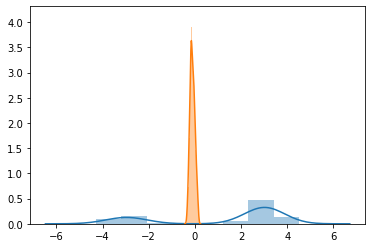

In [135]:
Y = sample_targets(1000)
GY = G(1000).detach().numpy()

sns.distplot(Y)
sns.distplot(GY)

In [136]:
g = G(10)
d = D(g)
t = D(sample_targets(10))
g.shape, d.shape, t.shape

(torch.Size([10, 1]), torch.Size([10, 1]), torch.Size([10, 1]))

In [137]:
def optimize(G, D, data_sampler, its, bs, lr):
    criterion = nn.BCELoss()

    g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

    def optimize_G():
        g_optimizer.zero_grad()
        loss = criterion(D(G(bs)), torch.ones(bs, 1))
        loss.backward()
        g_optimizer.step()
        
        return loss.item()

    def optimize_D():
        d_optimizer.zero_grad()
        real_loss = criterion(D(data_sampler(bs)), torch.ones(bs, 1))
        fake_loss = criterion(D(G(bs)), torch.zeros(bs, 1))
        real_loss.backward()
        fake_loss.backward()
        d_optimizer.step()
        
        return real_loss.item() + fake_loss.item()
        
    tr = trange(its)
    for i in tr:
        d_loss = optimize_D()
        g_loss = optimize_G()
        
        tr.set_description(
            'GL:%.5f / DL:%.5f' % (g_loss, d_loss)
        )

In [138]:
optimize(
    G=G,
    D=D,
    data_sampler=sample_targets,
    its=1000,
    bs=512,
    lr=0.001
)

GL:0.72965 / DL:1.36258: 100%|██████████| 1000/1000 [00:03<00:00, 264.64it/s]


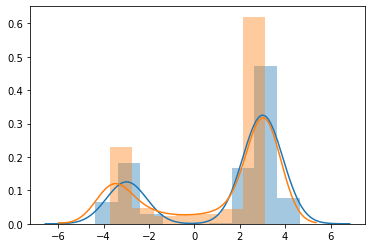

In [139]:
Y = sample_targets(1000)
GY = G(1000).detach().numpy()

sns.distplot(Y, norm_hist=True)
sns.distplot(GY, norm_hist=True)